# Detecting Credit Card Fraud Using Traditional Supervised Learning Models and Neural Networks with Regularization and Pruning methods

***Explore the dataset, list number of rows and columns, check sanity, examine
features (e.g. histograms/plots).***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd


# Locate and load the data file
df = pd.read_csv('~/HW/HW12_YahyaAlSabeh/EP_dataset/creditcard.csv')

# Sanity check
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.columns

N rows=284807, M columns=31


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
#Time variable should be an int
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  Int64  
 1   V1      284807 non-null  Float64
 2   V2      284807 non-null  Float64
 3   V3      284807 non-null  Float64
 4   V4      284807 non-null  Float64
 5   V5      284807 non-null  Float64
 6   V6      284807 non-null  Float64
 7   V7      284807 non-null  Float64
 8   V8      284807 non-null  Float64
 9   V9      284807 non-null  Float64
 10  V10     284807 non-null  Float64
 11  V11     284807 non-null  Float64
 12  V12     284807 non-null  Float64
 13  V13     284807 non-null  Float64
 14  V14     284807 non-null  Float64
 15  V15     284807 non-null  Float64
 16  V16     284807 non-null  Float64
 17  V17     284807 non-null  Float64
 18  V18     284807 non-null  Float64
 19  V19     284807 non-null  Float64
 20  V20     284807 non-null  Float64
 21  V21     28

In [4]:
columns = df.select_dtypes(include = ['float']).columns
columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [5]:
df_select = df.loc[:, df.columns.isin(['Time','Class', 'Amount'])]

df_select

,Time,Amount,Class
0,0,149.62,0
1,0,2.69,0
2,1,378.66,0
3,1,123.5,0
4,2,69.99,0
...,...,...,...
284802,172786,0.77,0
284803,172787,24.79,0
284804,172788,67.88,0
284805,172788,10.0,0


In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0],2), 'instances in the dataset')
print('Frauds', round(df['Class'].value_counts()[1],2), 'instances in the dataset')

No Frauds 284315 instances in the dataset
Frauds 492 instances in the dataset


## Check the class balance and pick an evaluation metric.

The class balance is very skewed. We should employ caution here and make sure that our testing and training datasets are stratified.

So we will use StratifiedKFold cross validation, and since we are solving a problem with fraud detection, we would rather detect all fraudulent activity than allow fraudulent activity to occur because we had limited information. What I'm getting at is that Recall is much more important here than Precision, so we should pick Recall as our evaluation metric.

/home/yahya/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yahya/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 6.79999999999999, 'time')

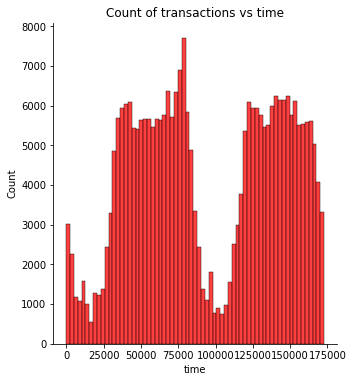

In [7]:
import seaborn as sns
#Target variable is heavily skewed
sns.displot(df['Time'].values, color='r')
plt.title('Count of transactions vs time')
plt.xlabel('time')




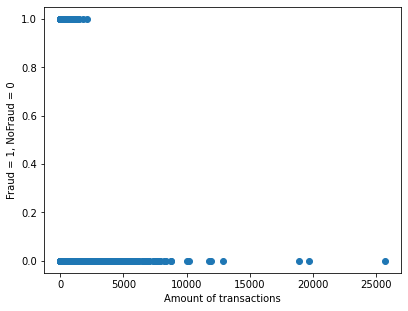

In [8]:
plt.scatter(x=df['Amount'].values, y=df['Class'].values)
plt.xlabel('Amount of transactions')
plt.ylabel('Fraud = 1, NoFraud = 0')
plt.show()

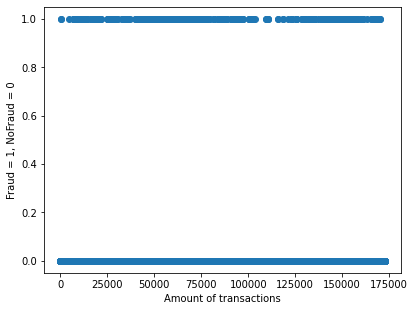

In [9]:
plt.scatter(x=df['Time'].values, y=df['Class'].values)
plt.xlabel('Amount of transactions')
plt.ylabel('Fraud = 1, NoFraud = 0')
plt.show()

/tmp/ipykernel_8291/319691755.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_val, color='r')
/home/yahya/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yahya/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_in

Text(0.5, 1.0, 'Distribution of Transaction Amount')

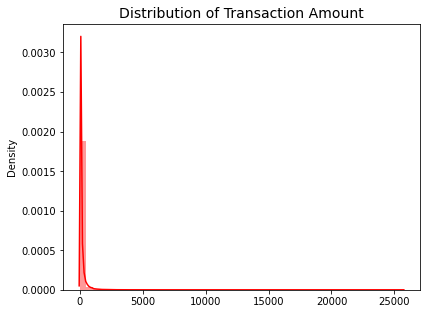

In [10]:
amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, color='r')
plt.title('Distribution of Transaction Amount', fontsize=14)

In [11]:
df[['Time','Amount','Class']].describe()

,Time,Amount,Class
count,284807.0,284807.0,284807.0
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.0,0.0,0.0
25%,54201.5,5.6,0.0
50%,84692.0,22.0,0.0
75%,139320.5,77.165,0.0
max,172792.0,25691.16,1.0


## Check if you need normalization or standardization, and justify. Complete pre-processing.

From this data it appears that most fraud coincided with the mean of the data; meaning that fraud happens randomly and it happens to coincide with the majority  of transaction amounts.

Fraud also does not appear to be correlated to any particular time point. Before moving on we will scale the time and amount data, using a Robust scaler since there are outliers in the dataset.

We will use standardization over normalization here because the data contains outliers, while would like to incorporate some information from outliers, the vast range of outliers from the sample mean in the Amount data, will alter the level of detail that is found near the mean of our dataset.

This will make any meaningful information from the Amount difficult to ascertain as we approach the mean when normalizing the dataset.

***Scaling/Normalization***

In [12]:
numerical = ['Time', 'Amount']

from sklearn.preprocessing import RobustScaler

rc = RobustScaler()
df[numerical]= rc.fit_transform(df[numerical])
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.16648,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.37978,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.1083,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,0.670579,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.034951,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.01448,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.296653,0
284803,1.034963,-0.732789,-0.05508,2.03503,-0.738589,0.868229,1.058415,0.02433,0.294869,0.5848,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,0
284804,1.034975,1.919565,-0.301254,-3.24964,-0.557828,2.630515,3.03126,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,0
284805,1.034975,-0.24044,0.530483,0.70251,0.689799,-0.377961,0.623708,-0.68618,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.167680,0


***Feature Selection***

<Axes: title={'center': 'Class Correlation'}>

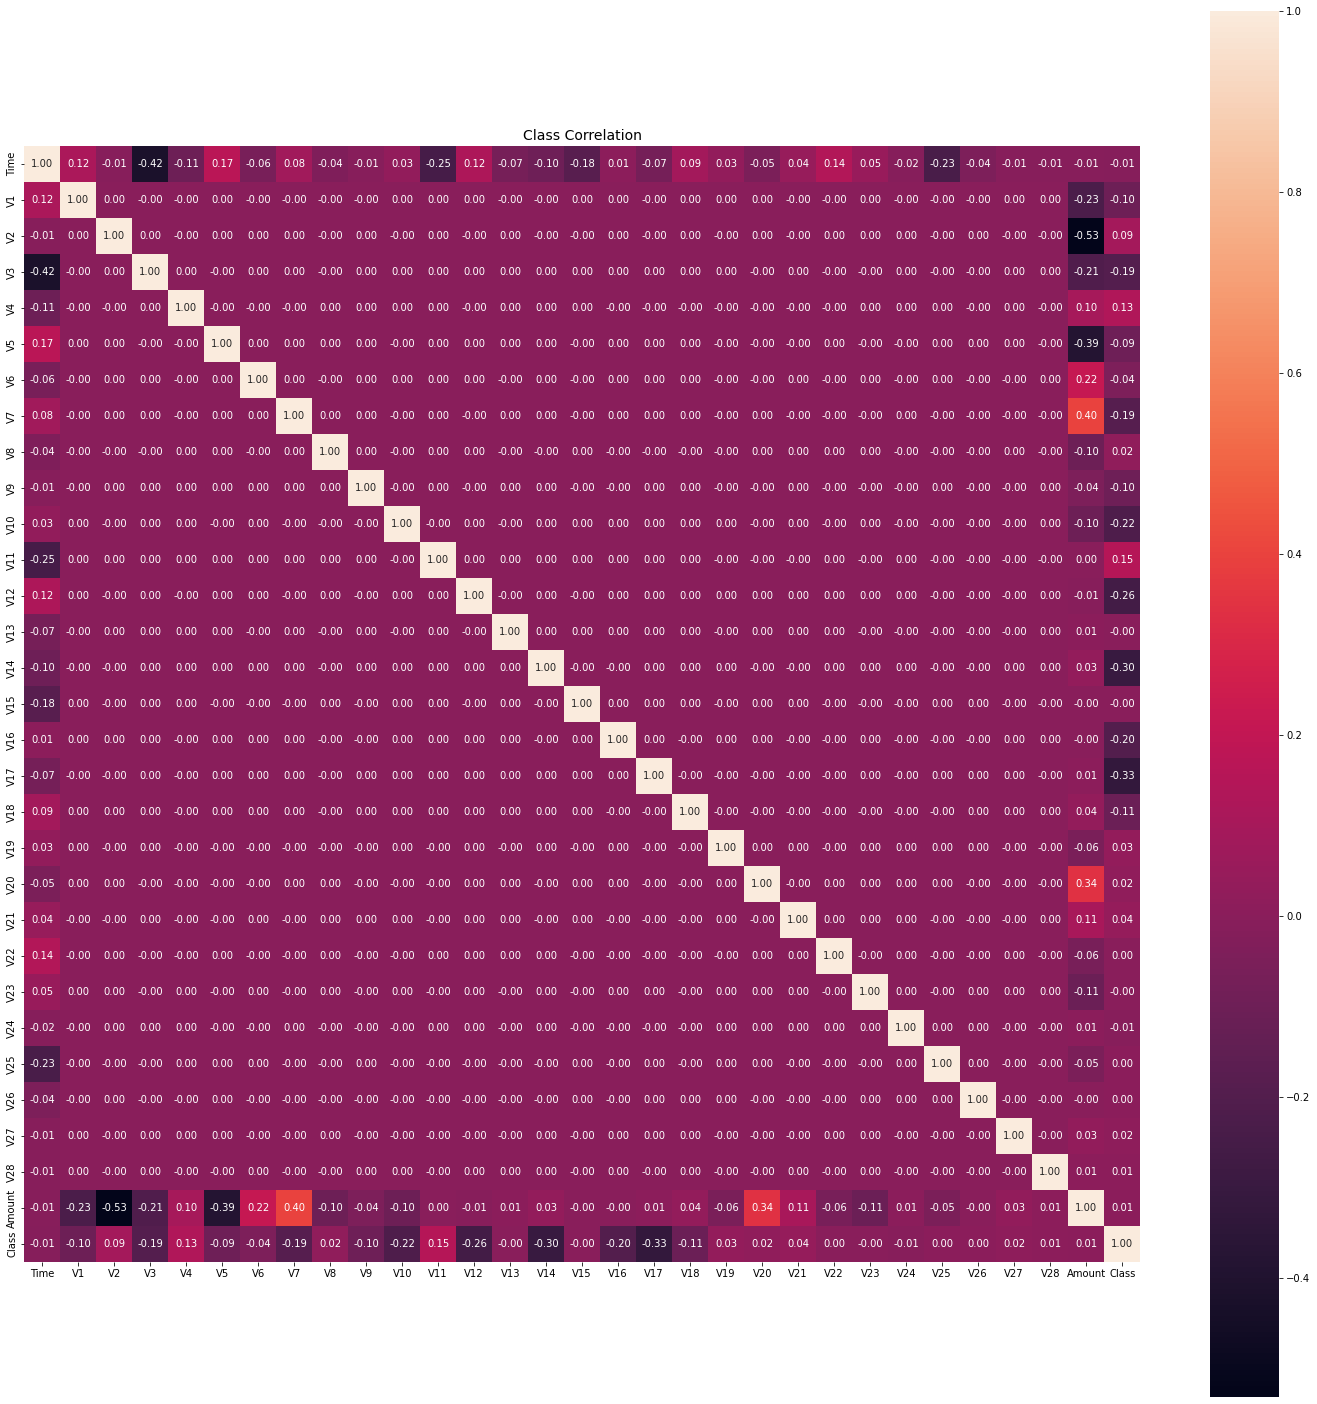

In [13]:
import seaborn as sns
dataCorr = df.corr()

#  print correlation
dataCorr['Class'].sort_values(ascending=False)

#  plot heatmap
plt.figure(figsize=(25,25))
plt.title('Class Correlation', fontsize=14)
sns.heatmap(dataCorr, annot=True, fmt='.2f', square=True)

In [14]:
#Most of the data is not linearly correlated, V17, V16, V14, V12, V10, V7, V3 are the features with the highest linear correlation to the class.
#Let's employ feature ranking to see if this holds...because unfortunately plotting this large amount of data is not feasible.

In [15]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
X_arr = X.values
y_arr = y.values.ravel()

print(X_arr[0:10], y_arr[0:10])

[[-0.9949834936970594 -1.3598071336738 -0.0727811733098497
  2.53634673796914 1.37815522427443 -0.338320769942518 0.462387777762292
  0.239598554061257 0.0986979012610507 0.363786969611213
  0.0907941719789316 -0.551599533260813 -0.617800855762348
  -0.991389847235408 -0.311169353699879 1.46817697209427
  -0.470400525259478 0.207971241929242 0.0257905801985591
  0.403992960255733 0.251412098239705 -0.018306777944153
  0.277837575558899 -0.110473910188767 0.0669280749146731
  0.128539358273528 -0.189114843888824 0.133558376740387
  -0.0210530534538215 1.7832739467616854]
 [-0.9949834936970594 1.19185711131486 0.26615071205963 0.16648011335321
  0.448154078460911 0.0600176492822243 -0.0823608088155687
  -0.0788029833323113 0.0851016549148104 -0.255425128109186
  -0.166974414004614 1.61272666105479 1.06523531137287 0.48909501589608
  -0.143772296441519 0.635558093258208 0.463917041022171
  -0.114804663102346 -0.183361270123994 -0.145783041325259
  -0.0690831352230203 -0.225775248033138 -0

In [16]:
# Direct correlation between each column of X and the target y
corrs = np.array([np.correlate(X_arr[:,j], y_arr)[0] for j in range(X.shape[1])])

# Reverse sort, numpy array negation reverses the order
ranks = np.argsort((-corrs))

# Display top-9 and bot-5
rankings = [(f'{corrs[j]:.1f}', X.columns[j]) for j in ranks]
display(rankings)

[('2234.7', 'V4'),
 ('1869.7', 'V11'),
 ('1782.9', 'V2'),
 ('688.9', 'Amount'),
 ('351.1', 'V21'),
 ('334.9', 'V19'),
 ('280.8', 'V8'),
 ('183.2', 'V20'),
 ('83.9', 'V27'),
 ('37.2', 'V28'),
 ('25.4', 'V26'),
 ('20.4', 'V25'),
 ('6.9', 'V22'),
 ('-19.8', 'V23'),
 ('-22.8', 'Time'),
 ('-45.7', 'V15'),
 ('-51.7', 'V24'),
 ('-53.8', 'V13'),
 ('-687.7', 'V6'),
 ('-1105.2', 'V18'),
 ('-1269.9', 'V9'),
 ('-1550.4', 'V5'),
 ('-2036.9', 'V16'),
 ('-2347.8', 'V1'),
 ('-2739.8', 'V7'),
 ('-2793.0', 'V10'),
 ('-3079.6', 'V12'),
 ('-3279.6', 'V17'),
 ('-3430.1', 'V14'),
 ('-3460.4', 'V3')]

From the correlation matrix we found that V17, V16, V14, V12, V10, V7, V3 are some of the best candidates to pick
Here we discover that V27, V28, V26, V25, V22, V23, Time, V15, V24, V13, and V6 have very poor rankings.

We already visualized that Time and the presence of fraud are not correlated, and that there is a greater correlation between the presence of fraud and the fraud amount simply due to the distribution of fraud amount.
So along with the other features it should be safe to eliminate the Time.

In [17]:
# Find columns with correlation=100.0 or less and then delete them from X
delcols = [(j, f'{corrs[j]:.1f}', X.columns[j]) for j in ranks if abs(corrs[j])<=500]

print(delcols)

[(21, '351.1', 'V21'), (19, '334.9', 'V19'), (8, '280.8', 'V8'), (20, '183.2', 'V20'), (27, '83.9', 'V27'), (28, '37.2', 'V28'), (26, '25.4', 'V26'), (25, '20.4', 'V25'), (22, '6.9', 'V22'), (23, '-19.8', 'V23'), (0, '-22.8', 'Time'), (15, '-45.7', 'V15'), (24, '-51.7', 'V24'), (13, '-53.8', 'V13')]


In [18]:
# Column numbers to delete
dd = [d[0] for d in delcols]

# Drop those columns, axis=1
Xpp = np.delete(np.array(X_arr, copy=True), dd, axis=1)

# Xpp is new pre-processed X

# Sanity check
print(f'{X.shape}, {Xpp.shape}')

(284807, 30), (284807, 16)


In [19]:
#Now we have 16 features left, we can go ahead and employ some ML algs and it won't take forever to run...

In [20]:
Xpp[0:10]

array([[-1.3598071336738, -0.0727811733098497, 2.53634673796914,
        1.37815522427443, -0.338320769942518, 0.462387777762292,
        0.239598554061257, 0.363786969611213, 0.0907941719789316,
        -0.551599533260813, -0.617800855762348, -0.311169353699879,
        -0.470400525259478, 0.207971241929242, 0.0257905801985591,
        1.7832739467616854],
       [1.19185711131486, 0.26615071205963, 0.16648011335321,
        0.448154078460911, 0.0600176492822243, -0.0823608088155687,
        -0.0788029833323113, -0.255425128109186, -0.166974414004614,
        1.61272666105479, 1.06523531137287, -0.143772296441519,
        0.463917041022171, -0.114804663102346, -0.183361270123994,
        -0.26982463494725073],
       [-1.35835406159823, -1.34016307473609, 1.77320934263119,
        0.379779593034328, -0.503198133318193, 1.80049938079263,
        0.791460956450422, -1.51465432260583, 0.207642865216696,
        0.624501459424895, 0.066083685268831, -0.165945922763554,
        -2.89008319

In [21]:
y_arr = y_arr.astype(int)
Xpp = Xpp.astype(float)
print(y_arr.dtype)
print(y_arr)
print(Xpp[0:10])

int64
[0 0 0 ... 0 0 0]
[[-1.35980713e+00 -7.27811733e-02  2.53634674e+00  1.37815522e+00
  -3.38320770e-01  4.62387778e-01  2.39598554e-01  3.63786970e-01
   9.07941720e-02 -5.51599533e-01 -6.17800856e-01 -3.11169354e-01
  -4.70400525e-01  2.07971242e-01  2.57905802e-02  1.78327395e+00]
 [ 1.19185711e+00  2.66150712e-01  1.66480113e-01  4.48154078e-01
   6.00176493e-02 -8.23608088e-02 -7.88029833e-02 -2.55425128e-01
  -1.66974414e-01  1.61272666e+00  1.06523531e+00 -1.43772296e-01
   4.63917041e-01 -1.14804663e-01 -1.83361270e-01 -2.69824635e-01]
 [-1.35835406e+00 -1.34016307e+00  1.77320934e+00  3.79779593e-01
  -5.03198133e-01  1.80049938e+00  7.91460956e-01 -1.51465432e+00
   2.07642865e-01  6.24501459e-01  6.60836853e-02 -1.65945923e-01
  -2.89008319e+00  1.10996938e+00 -1.21359313e-01  4.98372109e+00]
 [-9.66271712e-01 -1.85226008e-01  1.79299334e+00 -8.63291275e-01
  -1.03088796e-02  1.24720317e+00  2.37608940e-01 -1.38702406e+00
  -5.49519225e-02 -2.26487264e-01  1.78228226e-01

***Split the dataset 50-50 for training and testing. Then run SVC,
DecisionTreeClassifier, MLPClassifier, RandomForest without any tree pruning or
regularization. Report the classification performance. Then run SVC,
DecisionTreeClassifier, MLPClassifier with tree pruning and regularization (Hint: might
use GridSearchCV to optimize the regularization parameters; or simply run a few pilot tests).
Report the classification performance.***

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xpp, y_arr, test_size=0.5, random_state=1, shuffle=True, stratify=y_arr)

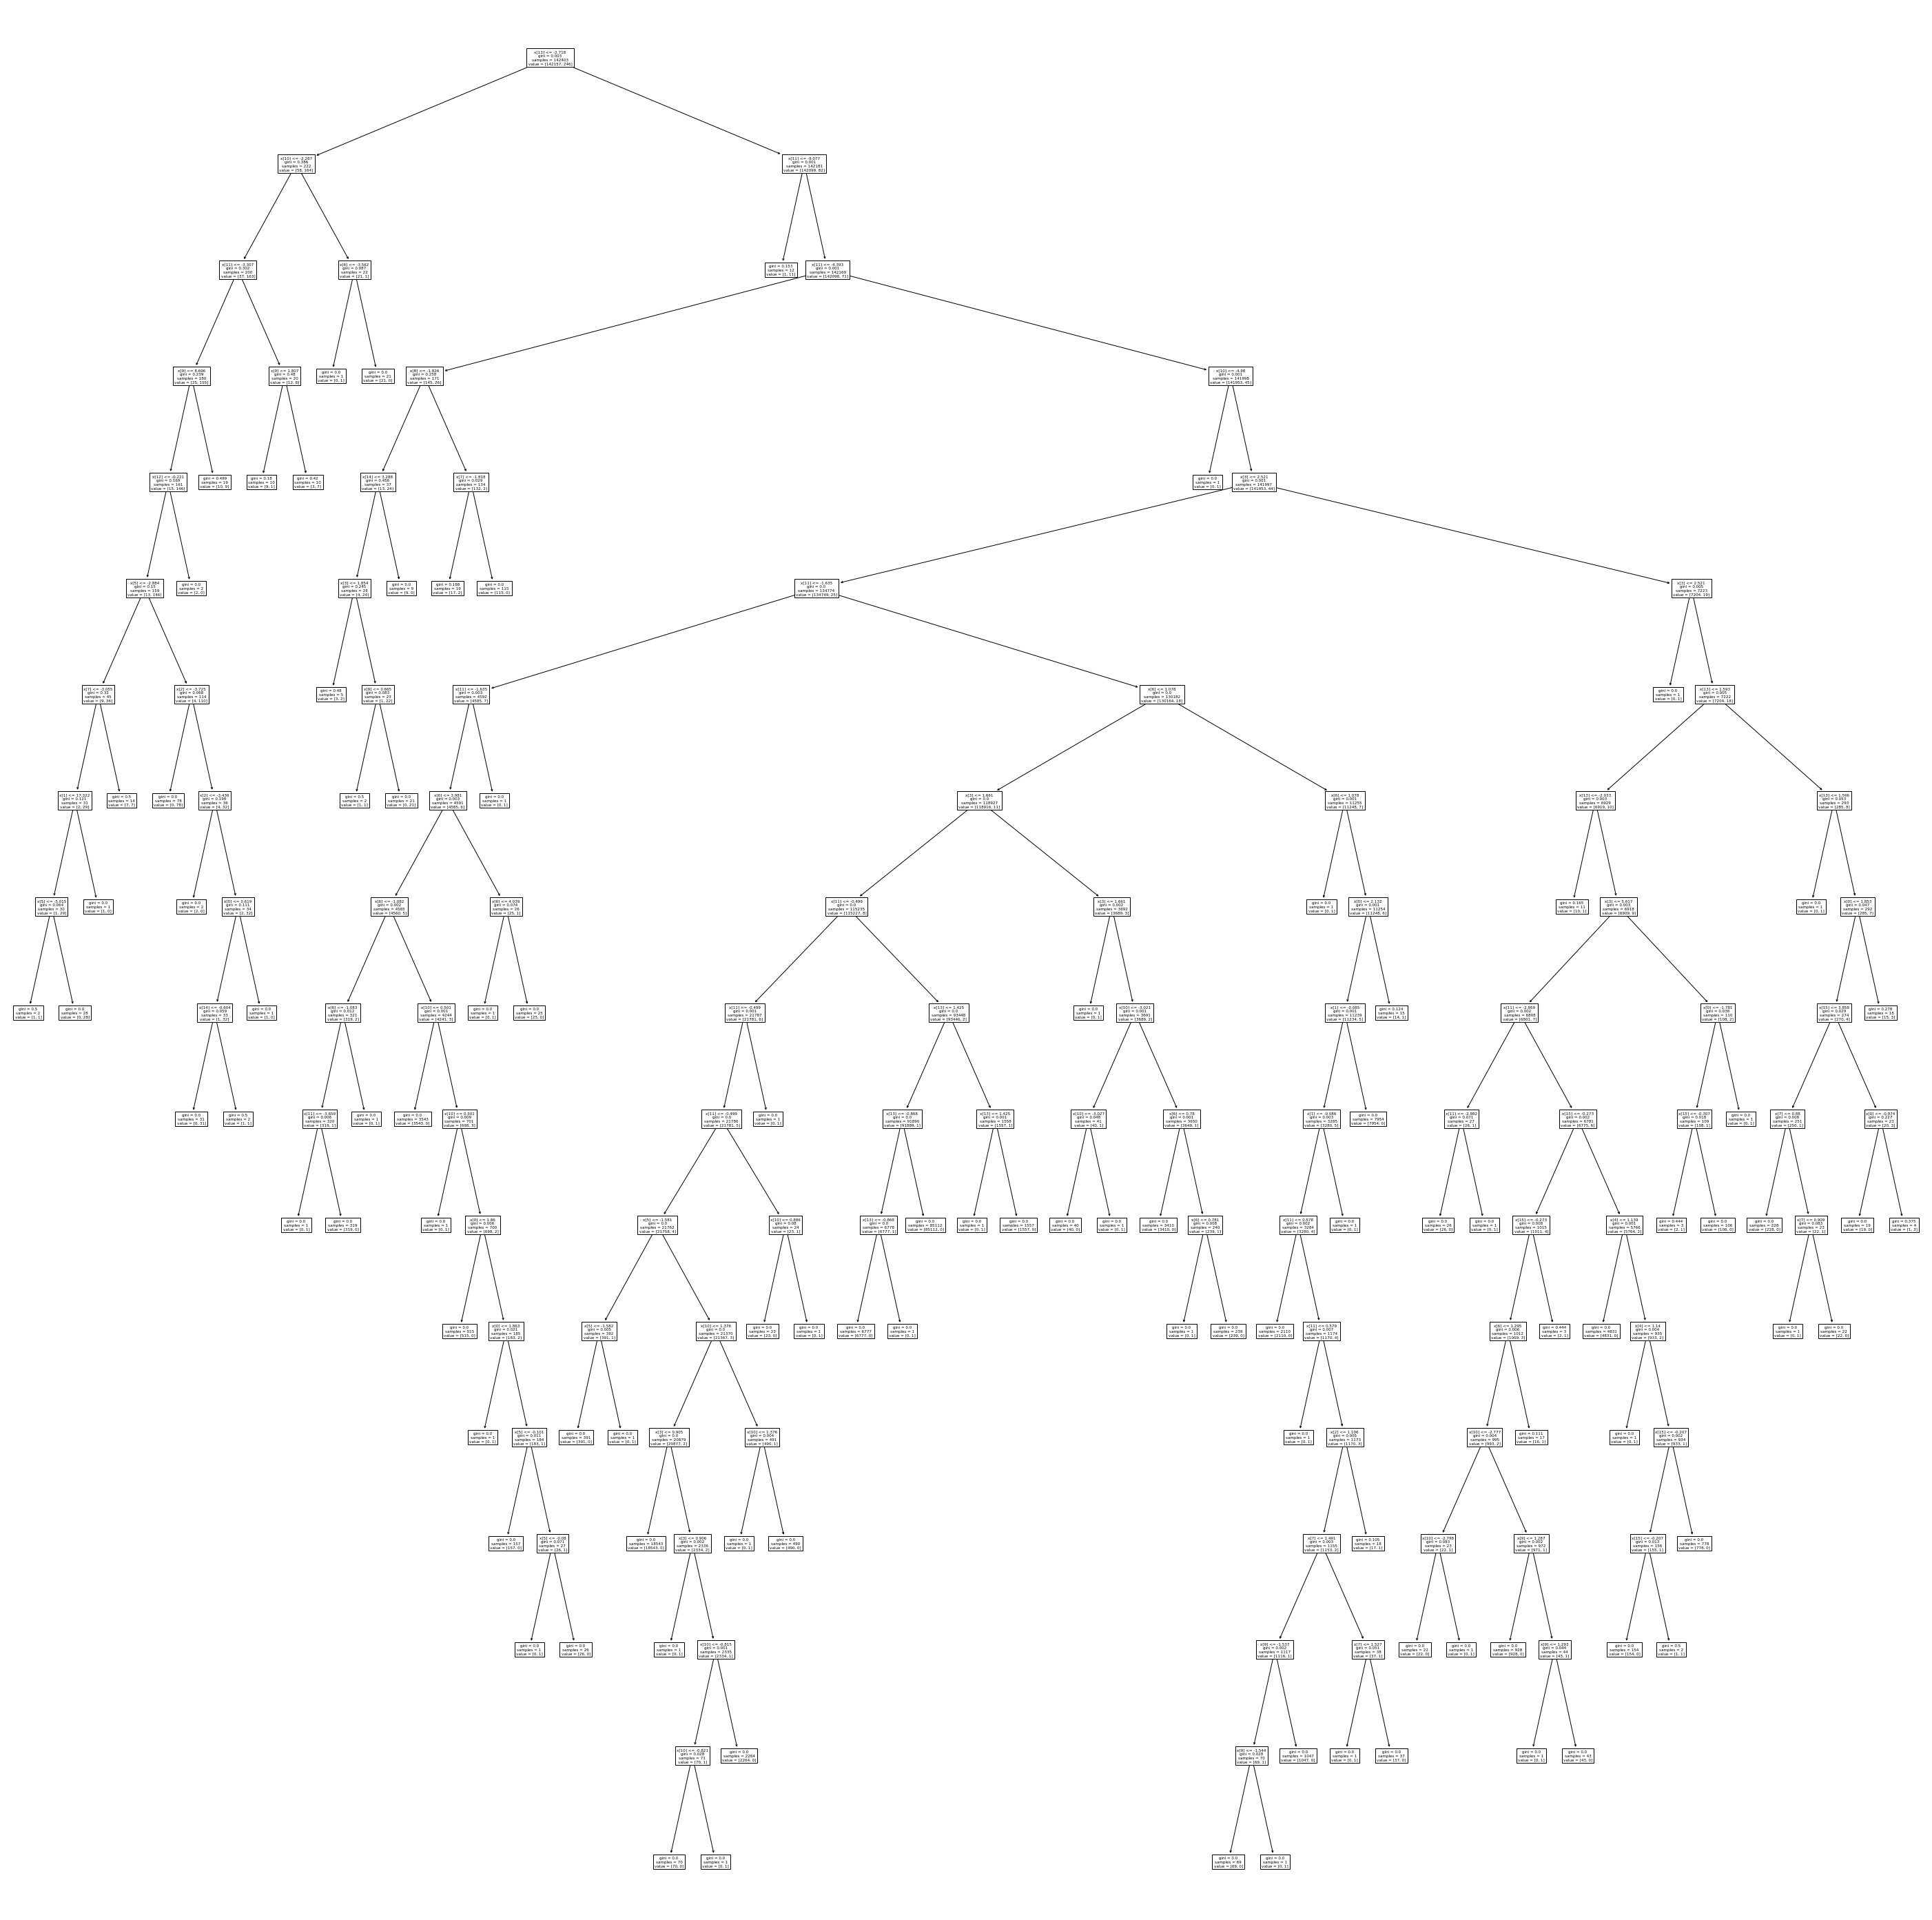

In [23]:
from sklearn import tree


clf1 = tree.DecisionTreeClassifier(random_state=20, min_samples_split=20).fit(X_train, y_train)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 50), dpi=72)
tree.plot_tree(clf1)

plt.show()

In [24]:
#What an unwieldly decision tree let's check it's performance via accuracy and recall
from sklearn.metrics import accuracy_score, recall_score


print(f'DT1 accuracy= {accuracy_score(y_test, clf1.predict(X_test)):.5f}')
print(f"DT1 recall= {recall_score(y_test, clf1.predict(X_test), average='binary', pos_label=1):.5f}")

DT1 accuracy= 0.99904
DT1 recall= 0.69919


### Pruning

Now we will report on the pruned decision tree

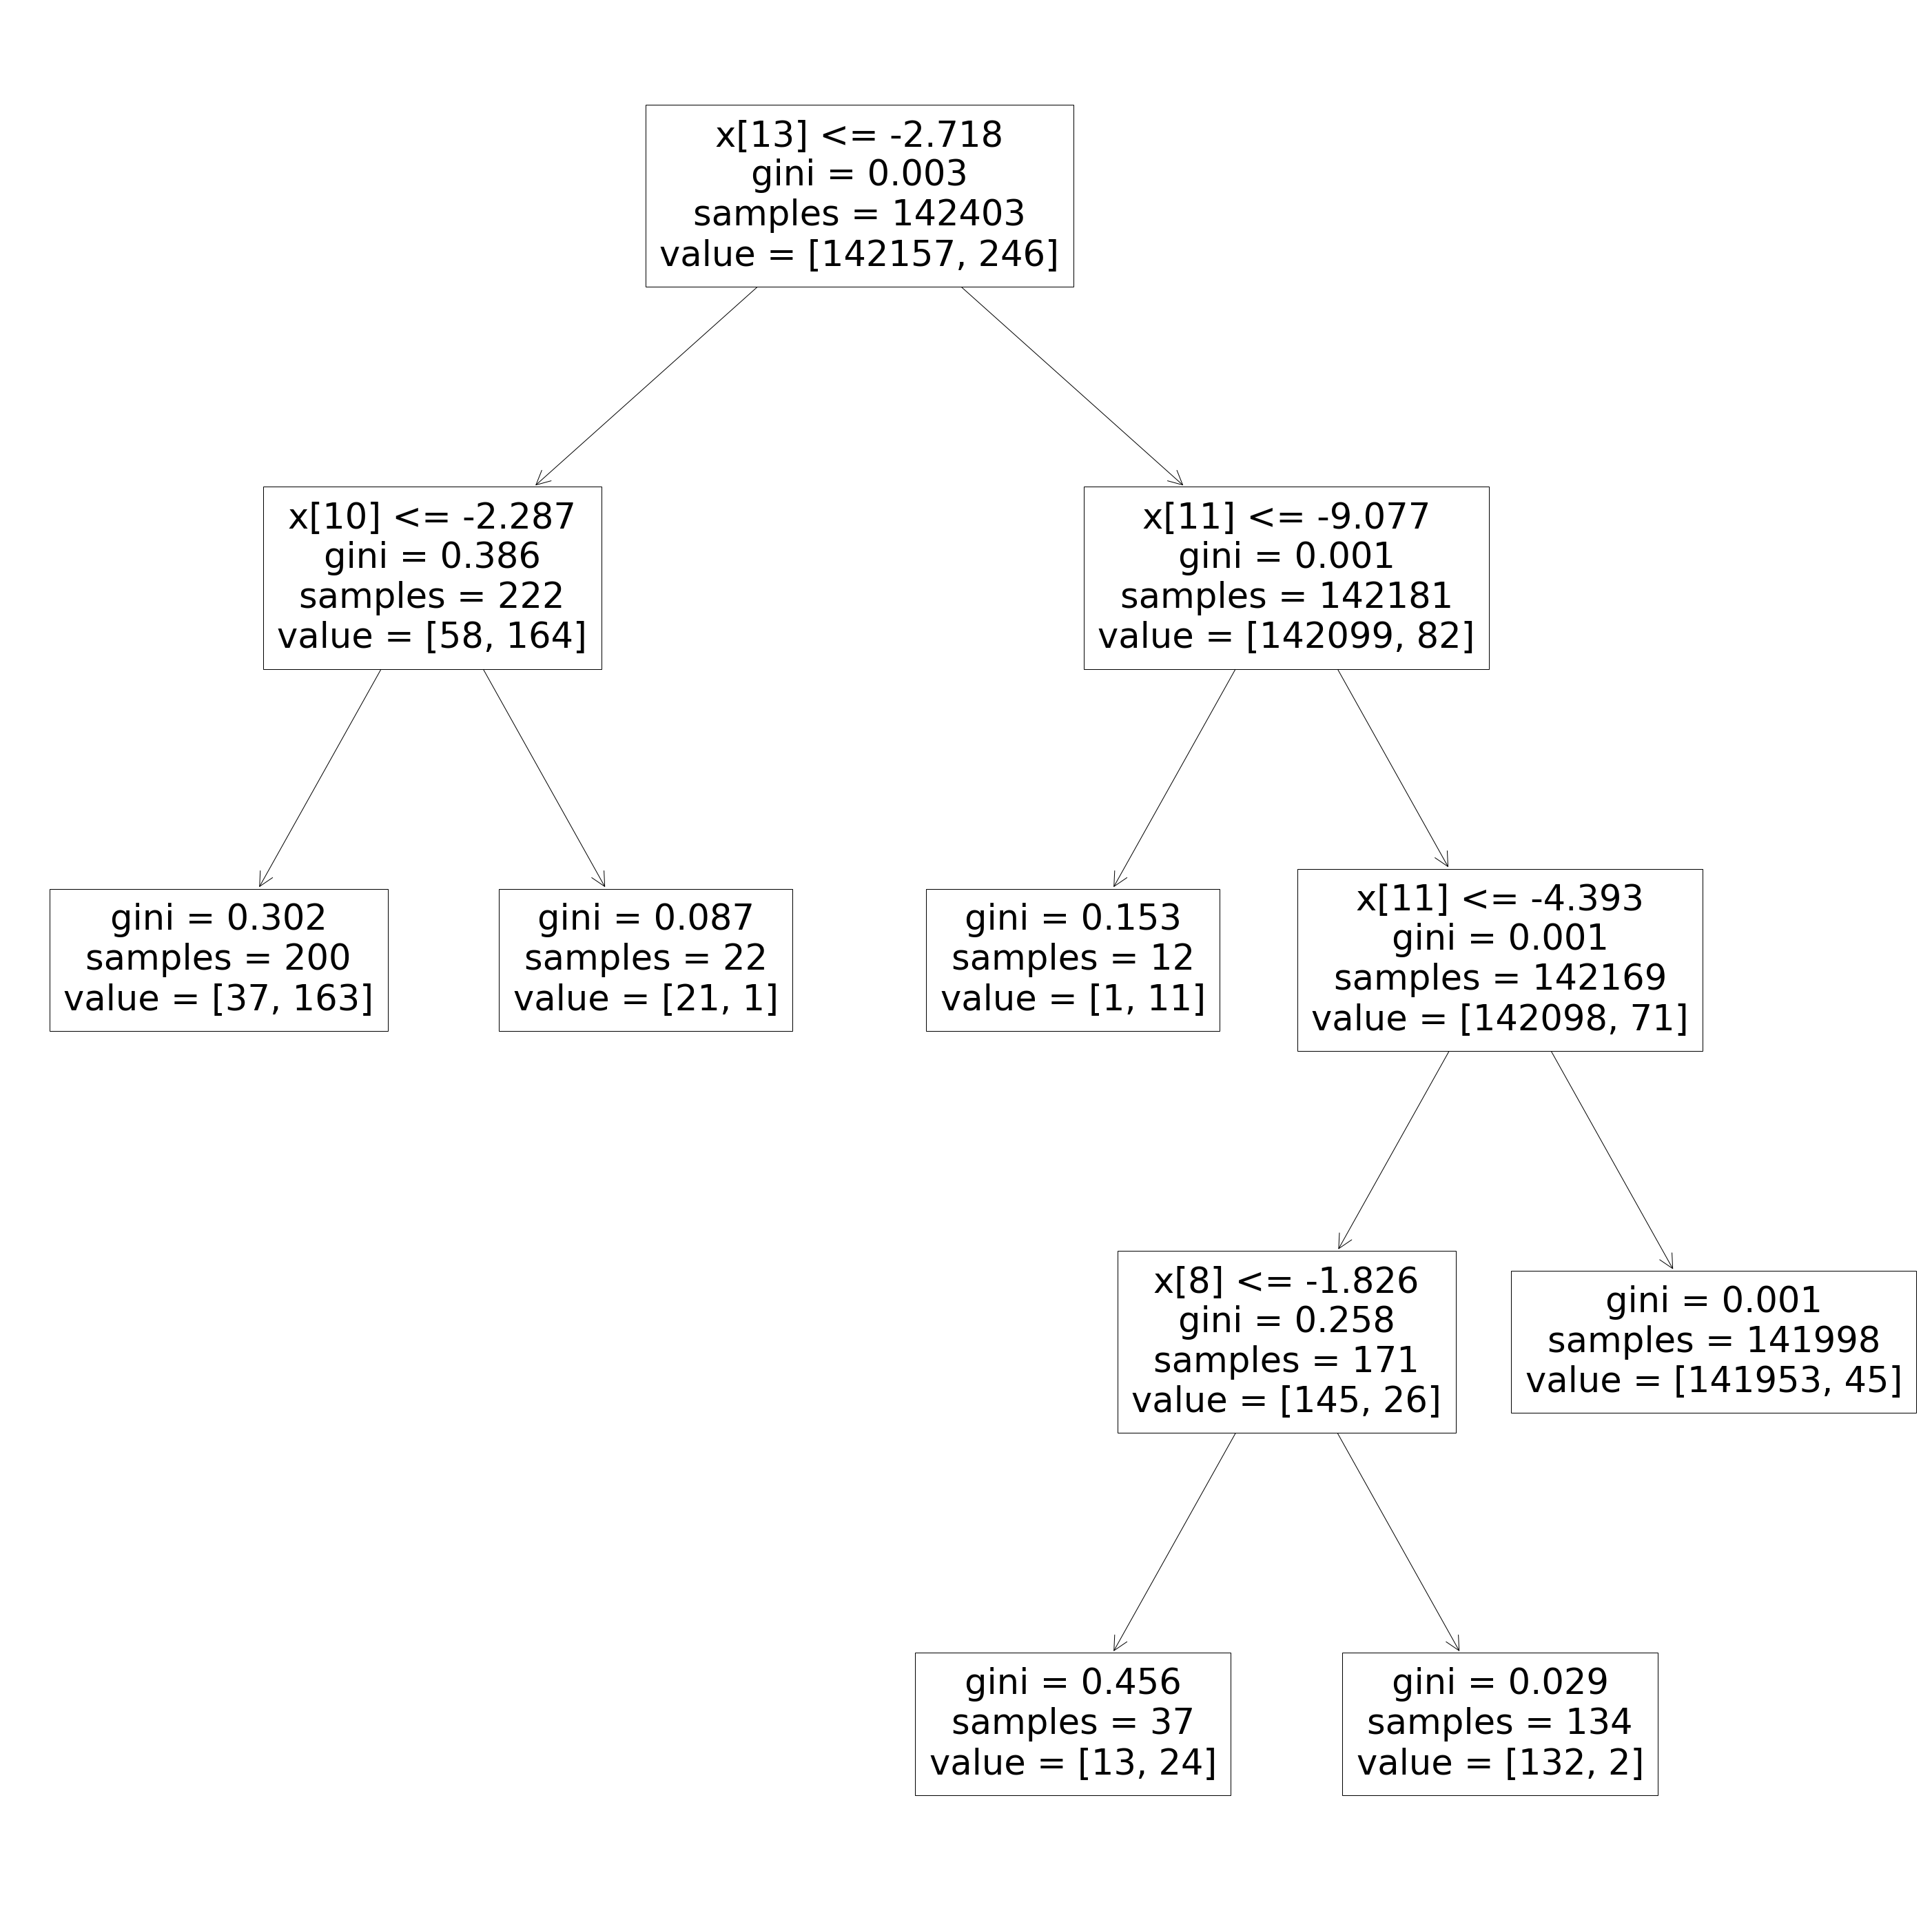

CPU times: user 4.63 s, sys: 43.7 ms, total: 4.68 s
Wall time: 4.68 s


In [25]:
%%time
Alpha = 0.0001

clf2 = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=Alpha).fit(X_train, y_train)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(50, 50), dpi=72)
tree.plot_tree(clf2)

plt.show()

In [26]:
%%time
print(f'DT2 accuracy= {accuracy_score(y_test, clf2.predict(X_test)):.5f}')
print(f"DT2 recall= {recall_score(y_test, clf2.predict(X_test), average='binary', pos_label=1):.5f}")

DT2 accuracy= 0.99942
DT2 recall= 0.83740
CPU times: user 58.1 ms, sys: 0 ns, total: 58.1 ms
Wall time: 57 ms


***As you can see the recall improved drastically here.***

Let's run simple MLP Classifiers, SVM, and Random Forest. Then enforce regularization on MLP and SVM classifiers and pruning on RF.

In [27]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=20, min_samples_split=20).fit(X_train, y_train)

print(f'DTRF1 accuracy= {accuracy_score(y_test, clf_rf.predict(X_test)):.5f}')
print(f"DTRF1 recall= {recall_score(y_test, clf_rf.predict(X_test), average='binary', pos_label=1):.5f}")

DTRF1 accuracy= 0.99956
DTRF1 recall= 0.81707
CPU times: user 1min 19s, sys: 59.5 ms, total: 1min 19s
Wall time: 1min 19s


In [72]:
%%time
clf_rf2 = RandomForestClassifier(random_state=20, min_samples_split=20, ccp_alpha=Alpha).fit(X_train, y_train)

print(f'DTRF2 accuracy= {accuracy_score(y_test, clf_rf2.predict(X_test)):.5f}')
print(f"DTRF2 recall= {recall_score(y_test, clf_rf2.predict(X_test), average='binary', pos_label=1):.5f}")

DTRF2 accuracy= 0.99933
DTRF2 recall= 0.71545
CPU times: user 1min 16s, sys: 0 ns, total: 1min 16s
Wall time: 1min 16s


### Now we will use regularization with MLP and SVM

In [57]:
%%time
from sklearn import svm

svc1 = svm.SVC()
clf_svc1 = svc1.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 0 ns, total: 1min 3s
Wall time: 1min 3s


In [65]:
%%time
from sklearn.model_selection import GridSearchCV
parameters = {'C':[1, 5]}
svc = svm.SVC()
clf2 = GridSearchCV(svc, parameters, scoring='recall', n_jobs=-1)
clf_svc2 = clf2.fit(X_train, y_train)

CPU times: user 25.4 s, sys: 96.3 ms, total: 25.4 s
Wall time: 3min 35s


In [66]:
%%time
print(f'DTSVC1 accuracy= {accuracy_score(y_test, clf_svc1.predict(X_test)):.5f}')
print(f"DTSVC1 recall= {recall_score(y_test, clf_svc1.predict(X_test), average='binary', pos_label=1):.5f}")

DTSVC1 accuracy= 0.99947
DTSVC1 recall= 0.74797
CPU times: user 17.5 s, sys: 0 ns, total: 17.5 s
Wall time: 17.5 s


In [67]:
%%time
print(f'DTSVC2 accuracy= {accuracy_score(y_test, clf_svc2.predict(X_test)):.5f}')
print(f"DTSVC2 recall= {recall_score(y_test, clf_svc2.predict(X_test), average='binary', pos_label=1):.5f}")

DTSVC2 accuracy= 0.99952
DTSVC2 recall= 0.77236
CPU times: user 15.3 s, sys: 7.31 ms, total: 15.3 s
Wall time: 15.3 s


In [33]:
from sklearn.neural_network import MLPClassifier

In [34]:
%%time
mlp1 = MLPClassifier(hidden_layer_sizes=(10,), alpha=0, random_state=0, max_iter=10000).fit(X_train,y_train)
mlp2 = MLPClassifier(hidden_layer_sizes=(10,), random_state=0, max_iter=10000)

parameters = {'alpha':[0.005, 0.05, 0.1]}
mlp2_gs = GridSearchCV(mlp2, parameters, scoring='recall', n_jobs=-1)

mlp2_fit = mlp2_gs.fit(X_train, y_train)


CPU times: user 7.88 s, sys: 24 ms, total: 7.9 s
Wall time: 40.8 s


In [35]:
%%time
print(f'MLP1 accuracy= {accuracy_score(y_test, mlp1.predict(X_test)):.5f}')
print(f"MLP1 recall= {recall_score(y_test, mlp1.predict(X_test), average='binary', pos_label=1):.5f}")

MLP1 accuracy= 0.99947
MLP1 recall= 0.81301
CPU times: user 209 ms, sys: 86 µs, total: 209 ms
Wall time: 61.5 ms


In [36]:
%%time
print(f'MLP2 accuracy= {accuracy_score(y_test, mlp2_fit.predict(X_test)):.5f}')
print(f"MLP2 recall= {recall_score(y_test, mlp2_fit.predict(X_test), average='binary', pos_label=1):.5f}")

MLP2 accuracy= 0.99946
MLP2 recall= 0.78049
CPU times: user 289 ms, sys: 8.06 ms, total: 297 ms
Wall time: 112 ms


We did all of our experiments maintaining the same parameters between each test. Running pilot tests for the Decision Tree showed that a Decision Tree with pruning gains generlizeability is able to outperform a standard decision tree in terms of recall. We chose recall again in these tests because the rate of the Fraud is so limited in our dataset and we seek to catch all Fraud cases. By pruning we had a smaller decision tree, and a more robust model that was able to catch a greater percentage of rare positive cases. 

This trend unfortunately didn't hold with the Random Forest, perhaps the alpha score from a decision tree does not directly relate to a similar strength Random Forest alpha, or perhaps the combination of bagging and pruning leads to most trees not being exposed to the positive class in large enough proportion to influence the vote.

Implementing neural networks with MLP classifiers and a regularization parameter discovered through GridSearchCV prioritizing recall, showed a significant improvement. The optimal regularization term for MLP's is signifantly lower than that used for the SVM SVC.

SVM SVC also enjoyed greater performance via the implementation of the regularization parameter, this performance could be improved upon with a more extensive GridSearch parameter search.

**We will script a PyTorch neural network with a hidden layer (might experiment with 2
hidden layers, size might be 20 to 40). Report the classification performance on the
previous 50-50 dataset. Expect a similar performance to the neural network in Q4.**

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch

print(f'PyTorch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')  # CUDA optional - True when GPU present, CUDA installed

PyTorch version= 2.1.1
CUDA available= False


In [38]:
class PyTorchMLP(torch.nn.Module):  # One hidden layer
    def __init__(self, n_hidden=10, epochs=100, eta=0.001, minibatch_size=50, seed=0):
        super(PyTorchMLP, self).__init__()
        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.n_hidden = n_hidden  # size of the hidden layer
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work
        self.optimizer = None
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.model = None

    def init_layers(self, _M:int, _K:int) -> None:
        # data structure
        self.model = torch.nn.Sequential(
            torch.nn.Linear(_M, self.n_hidden),  #input layer
            torch.nn.Sigmoid(),
            torch.nn.Linear(self.n_hidden, self.n_hidden),#first layer
            torch.nn.Sigmoid(),
            torch.nn.Linear(self.n_hidden, self.n_hidden), #second layer
            torch.nn.Sigmoid(),
            torch.nn.Linear(self.n_hidden, _K),  #output layer
        )
    
    def predict(self, _X):
        _X = torch.FloatTensor(_X)
        assert self.model is not None
        self.model.eval()
        with torch.no_grad():
            y_pred = np.argmax(self.model(_X), axis=1)
        self.model.train()
        return y_pred.numpy()

    def fit(self, _X_train, _y_train, info=False):
        import sys
        _X_train, _y_train = torch.FloatTensor(_X_train), torch.LongTensor(_y_train)
        n_features= _X_train.shape[1]
        n_output= np.unique(_y_train).shape[0]  # number of class labels
        
        self.init_layers(n_features, n_output)
        self.optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)  # connect model to optimizer

        for i in range(self.epochs):
            indices = np.arange(_X_train.shape[0])
            self.random.shuffle(indices)  # shuffle the data each epoch

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                self.optimizer.zero_grad()
                
                net_out = self.model(_X_train[batch_idx])
                
                loss = self.loss_func(net_out, _y_train[batch_idx])
                loss.backward()
                self.optimizer.step()
                
                if info:
                    sys.stderr.write(f"\r{i+1:03d} Loss: {loss.item():6.5f}")
                    sys.stderr.flush()
        return self

## Dropout

**Add dropout to the PyTorch neural network and repeat the previous step. Note that
a robust model with a comparable performance to Q4. or Q5. is always preferred. Why?**

In [39]:
# A derived class to have Dropout
class MLP2(PyTorchMLP):
    def init_layers(self, _M, _K):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(_M, self.n_hidden),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(self.n_hidden, self.n_hidden), #first hidden layer
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(self.n_hidden, self.n_hidden), #second hidden layer
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(self.n_hidden, _K),
        )

In [40]:
%%time
# Train
mlp1 = PyTorchMLP(n_hidden=40, epochs=500, eta=0.0001, minibatch_size=X_train.shape[0]).fit(X_train,y_train)
mlp2 = MLP2(n_hidden=40, epochs=500, eta=0.0001, minibatch_size=X_train.shape[0]).fit(X_train,y_train)

CPU times: user 7min 47s, sys: 17.5 s, total: 8min 4s
Wall time: 2min 5s


In [41]:
%%time
from sklearn.metrics import accuracy_score, recall_score

print(f'Pytorch Standard accuracy= {accuracy_score(y_test, mlp1.predict(X_test)):.5f}')
print(f"Pytorch Standard  recall= {recall_score(y_test, mlp1.predict(X_test), average='binary', pos_label=1):.5f}")

Pytorch Standard accuracy= 0.99902
Pytorch Standard  recall= 0.78049
CPU times: user 397 ms, sys: 7.74 ms, total: 405 ms
Wall time: 109 ms


In [42]:
print(f'Pytorch DropOut accuracy= {accuracy_score(y_test, mlp2.predict(X_test)):.5f}')
print(f"Pytorch DropOut  recall= {recall_score(y_test, mlp2.predict(X_test), average='binary', pos_label=1):.5f}")

Pytorch DropOut accuracy= 0.99949
Pytorch DropOut  recall= 0.80488


Even with similar training parameters drop out comes out on top, this is because the removal of nodes in each training step, forces other nodes to retain redundant information. That redundant information smooths out the decision boundary, it basically forces adjacent nodes to retain partial information from it's previous layer, this prevents node co-dependency and results in a more robust model with a smoother decision boundary.

### Evaluate the 10-fold cross validation of Random Forest and two PyTorch neural networks

In [43]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

def kfold_eval_docs(_clf, _X, _y):
    accs = []
    recs = []
    count = 0
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        ypred = _clf.predict(_X[test_index])
        accs += [accuracy_score(_y[test_index], ypred)]
        recs += [recall_score(_y[test_index], ypred)]
        count +=1
        print('Round ', count)

    return np.array(accs), np.array(recs)

CPU times: user 39 µs, sys: 1e+03 ns, total: 40 µs
Wall time: 13.1 µs


In [44]:
%%time
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=20, max_depth=5, min_samples_split=100)
acc, rec = kfold_eval_docs(rf, Xpp, y_arr)
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV recall={np.mean(rec):.3f} {np.std(rec):.3f}')

Round  1
Round  2
Round  3
Round  4
Round  5
Round  6
Round  7
Round  8
Round  9
Round  10
Random Forest CV accuracy=0.999 0.000
Random Forest CV recall=0.740 0.066
CPU times: user 9min 46s, sys: 993 ms, total: 9min 47s
Wall time: 9min 47s


In [54]:
%%time
mlp1 = PyTorchMLP(n_hidden=40, epochs=500, eta=0.0001, minibatch_size=X_train.shape[0])
acc, rec = kfold_eval_docs(mlp1, Xpp, y_arr)
print(f'Pytorch Standard CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Pytorch Standard CV recall={np.mean(rec):.3f} {np.std(rec):.3f}')

Round  1
Round  2
Round  3
Round  4
Round  5
Round  6
Round  7
Round  8
Round  9
Round  10
Pytorch Standard CV accuracy=0.999 0.000
Pytorch Standard CV recall=0.778 0.046
CPU times: user 22min 10s, sys: 9.21 s, total: 22min 19s
Wall time: 5min 39s


In [55]:
%%time
mlp2 = MLP2(n_hidden=40, epochs=1000, eta=0.0001, minibatch_size=X_train.shape[0])
acc, rec = kfold_eval_docs(mlp2, Xpp, y_arr)
print(f'Pytorch DropOut CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Pytorch DropOut CV recall={np.mean(rec):.3f} {np.std(rec):.3f}')

Round  1
Round  2
Round  3
Round  4
Round  5
Round  6
Round  7
Round  8
Round  9
Round  10
Pytorch DropOut CV accuracy=0.999 0.000
Pytorch DropOut CV recall=0.785 0.045
CPU times: user 1h 13min 47s, sys: 2min 3s, total: 1h 15min 51s
Wall time: 19min 37s


Finally we performed 10-Fold CV with a standard RF, a 2-HLayer neural network without dropout and a 2-HLayer neural network with dropout. The dropout parameters here could be increased for greater performance, but the expense of computation for these tests makes exploration of different parameters difficult. Regardless, the neural network had higher performance than the Random Forest. And a Neural Network implementing node dropout performed better than the standard neural network.